In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import subprocess
import time
import pyautogui
import pygetwindow as gw


In [2]:
from source.IB_connector import retrive_market_data

ticker = "AAPL"
# training_set_aapl = retrive_market_data([ticker], duration = "9 m", time_interval = "15 mins")
# training_set = training_set_aapl[ticker]
# training_set['Volume'] = training_set['Volume'].astype(float)
# training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")

In [3]:
# training_set.columns

In [4]:
from source.database import upload_stock_data, read_stock_data
# training_set['ticker'] = ticker

# upload_stock_data(training_set)
# training_set.head()

In [5]:
train_df, val_df ,rl_df,test_df = read_stock_data(ticker)

full_df = pd.concat([train_df, val_df ,rl_df,test_df], axis = 0)
min_value = full_df['close'].min()
max_value = full_df['close'].max()

In [6]:
max_value

258.77

In [7]:
#col_select = ['Open','High','Low','Close','Volume']
col_select = ['open','high','low','close','volume']

train_df, val_df ,rl_df,test_df = train_df[col_select], val_df[col_select], rl_df[col_select], test_df[col_select]
# training_set = training_set[col_select]
# training_set.dtypes
CLOSE_INDEX = col_select.index('close')

In [8]:
# n = len(training_set)
# train_df = training_set[0:int(n*0.4)]
# val_df = training_set[int(n*0.4):int(n*0.5)]
# rl_df = training_set[int(n*0.5):int(n*0.9)]
# test_df = training_set[int(n*0.9):]

In [9]:
train_mean = train_df.mean(numeric_only=True)
train_std = train_df.std(numeric_only=True)

In [10]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [11]:
from torch.utils.data import Dataset, DataLoader
from source.LSTMdataset import WindowDataset, WindowGenerator

OUT_STEPS = 16


w1 = WindowGenerator(input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS, 
                    train_df=train_df, val_df=val_df, test_df=test_df, 
                    label_columns=['close'])
# Stworzenie datasetu:
train_dataset = w1.make_dataset(train_df.values)  # Zakładając, że train_df to np. pandas.DataFrame
val_dataset = w1.make_dataset(val_df.values)  # Zakładając, że train_df to np. pandas.DataFrame

# DataLoader:
BATCH_SIZE = 512 # 256 * 2 = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
from LSTMmodel import MultiLSTMModel, MAPELoss
num_epochs = 2000
learning_rate = 0.014

num_features = 5
input_size = num_features
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm.to(device)

MultiLSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
criterion = MAPELoss()
early_stopper = EarlyStopper(patience=50, min_delta=0.2)

for epoch in range(num_epochs):
  
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = lstm(inputs)
      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      
      loss.backward()
      
      optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    validation_loss = loss.item()
    if early_stopper.early_stop(validation_loss):             
        break


c:\Users\proso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 0, loss: 96.61372
Epoch: 100, loss: 26.47446
Epoch: 200, loss: 21.82171
Epoch: 300, loss: 15.51301


In [15]:
#torch.save(lstm.state_dict(), 'appl_15min_8m_LSTM.pth')

In [16]:
i = 0 
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = lstm(inputs)
    
    loss = criterion(outputs, labels)    
    leb = labels.detach().cpu().numpy()*train_std[3] + train_mean[3]
    pred = outputs.detach().cpu().numpy()*train_std[3] + train_mean[3]
    print(loss.item())
    print("MAPE ", np.mean(np.abs(leb - pred) / leb * 100) )
    print("MAE ", np.mean(np.abs(leb - pred)) )


156.76869201660156
MAPE  0.9249771
MAE  2.150148


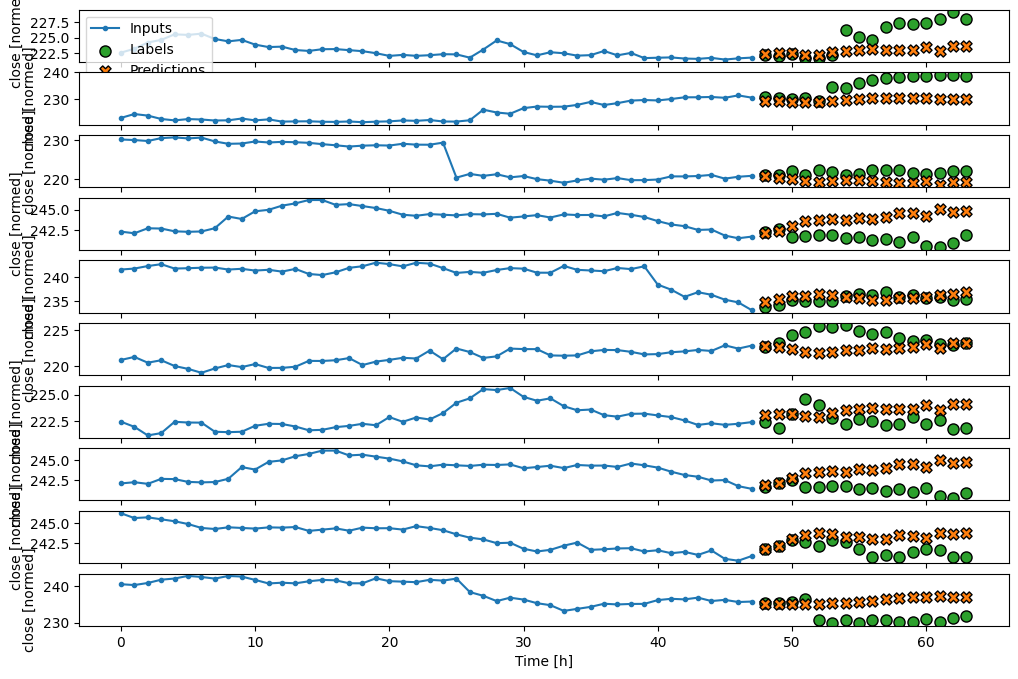

In [17]:
inpu = inputs.detach().cpu().numpy()*train_std[CLOSE_INDEX] + train_mean[CLOSE_INDEX]

w1.example = inpu, leb

w1.plot(pred, max_subplots=10, plot_col='close')

In [12]:
import numpy as np
import gym
from gymnasium import spaces
import torch

class TimeSeriesEnvFuturePredict_VEC(gym.Env):
    def __init__(self, data, lstm, lstm_data, train_std, train_mean, device, window_size=10, future_size=16):
        self.data = data.astype(np.float32)
        self.window_size = window_size
        self.future_size = future_size
        self.current_step = window_size
        self.device = device
        self.lstm = lstm
        self.lstm_data = lstm_data.astype(np.float32)
        self.train_std = float(train_std)
        self.train_mean = float(train_mean)

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(window_size + future_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        if self.current_step >= len(self.data):
            raise ValueError("Dane są zbyt krótkie, by zobaczyć przyszłe punkty.")

        return self._get_observation(), {}

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        past_lstm = self.lstm_data[self.current_step - self.window_size:self.current_step].astype(np.float32)

        inputs = torch.from_numpy(past_lstm.astype(np.float32)).float().to(self.device)
        outputs = self.lstm(inputs)
        future = outputs.detach().cpu().numpy().flatten().astype(np.float32)

        past = (past - self.train_mean) / self.train_std
        obs = np.concatenate([past, future])
        return np.round(obs.astype(np.float32), 3)

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit
            self.total_profit += profit
            self.states_sell.append(self.current_step)

        self.current_step += 1

        if self.current_step >= len(self.data):
            terminated = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))

        return self._get_observation(), reward, terminated, truncated, {}


In [15]:

class TimeSeries_VEC(gym.Env):
    def __init__(self, data, lstm_data, max_val, min_val, device, window_size=10, future_size=16):
        self.data = data.astype(np.float32)
        self.window_size = window_size
        self.future_size = future_size
        self.current_step = window_size
        self.device = device
        #self.lstm = lstm
        self.lstm_data = lstm_data.astype(np.float32)
        self.max_val = float(max_val)
        self.min_val = float(min_val)

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(window_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        if self.current_step >= len(self.data):
            raise ValueError("Dane są zbyt krótkie, by zobaczyć przyszłe punkty.")

        return self._get_observation(), {}

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        #past_lstm = self.lstm_data[self.current_step - self.window_size:self.current_step].astype(np.float32)

        #inputs = torch.from_numpy(past_lstm.astype(np.float32)).float().to(self.device)
        #outputs = self.lstm(inputs)
        #future = outputs.detach().cpu().numpy().flatten().astype(np.float32)

        #past = (past - self.train_mean) / self.train_std
        #obs = np.concatenate([past, future])
        return ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)
        #return np.round(past.astype(np.float32), 3)

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit
            self.total_profit += profit
            self.states_sell.append(self.current_step)

        self.current_step += 1

        if self.current_step >= len(self.data):
            terminated = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))

        return self._get_observation(), reward, terminated, truncated, {}


NameError: name 'gym' is not defined

In [25]:
#from enviroments import TimeSeriesEnvFuturePredict, TimeSeriesEnv
# env = TimeSeriesEnvFuturePredict_VEC(data=rl_df['close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
#                                   train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)



#min_value
#env = TimeSeriesEnv(rl_df['Close'].values, 96)

In [26]:
#env._get_observation()

In [27]:
# from gymnasium.vector import AsyncVectorEnv
# def make_env(data, lstm, lstm_data, device, train_std, train_mean, window_size, future_size):
#     def thunk():
#         return TimeSeriesEnvFuturePredict_VEC(
#             data=data, 
#             lstm=lstm, 
#             lstm_data=lstm_data, 
#             device=device,
#             train_std=train_std, 
#             train_mean=train_mean, 
#             window_size=window_size, 
#             future_size=future_size
#         )
#     return thunk

# NUM_ENVS = 8
# # envs = AsyncVectorEnv([make_env(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
# #                                   train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS) for _ in range(NUM_ENVS)])
# env_fns = [
#             make_env(
#                 data=rl_df['close'].values, 
#                 lstm=lstm,
#                 lstm_data=rl_df.values,
#                 device=device,
#                 train_std=float(train_std[CLOSE_INDEX]),
#                 train_mean=float(train_mean[CLOSE_INDEX]), 
#                 window_size=48, 
#                 future_size=OUT_STEPS
#             ) for _ in range(NUM_ENVS)
#         ] 

# envs = AsyncVectorEnv(env_fns)

# states, _ = envs.reset()

In [30]:
from gymnasium.vector import AsyncVectorEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_env(data, lstm_data, device, min_value, max_value, window_size):
    def thunk():
        return TimeSeries_VEC(
            data=data, 
            #lstm=lstm, 
            lstm_data=lstm_data, 
            device=device,
            min_val=min_value, 
            max_val=max_value, 
            window_size=window_size
            )
    return thunk

NUM_ENVS = 8
# envs = AsyncVectorEnv([make_env(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
#                                   train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS) for _ in range(NUM_ENVS)])
env_fns = [
            make_env(
                data=rl_df['close'].values, 
                #lstm=lstm,
                lstm_data=rl_df.values,
                device=device,
                min_value=float(min_value),
                max_value=float(max_value), 
                window_size=48
                ) for _ in range(NUM_ENVS)
        ] 

envs = AsyncVectorEnv(env_fns)

states, _ = envs.reset()

In [2]:
from enviroments import TimeSeriesEnv
import numpy as np
data = np.sin(np.linspace(0, 100, 500)).astype(np.float32)

env = TimeSeriesEnv(
                data=data,#rl_df['close'].values, 
                #lstm_data=rl_df.values,
                #device=device,
                min_val=-1,#float(min_value),
                max_val=1,#float(max_value), 
                window_size=48        )

In [11]:
from rl_agent import DQNAgent, train_episode, train_parallel_episode


agent = DQNAgent(observation_space=48, action_space=3, AGGREGATE_STATS_EVERY=20, EPSILON=1, EPSILON_DECAY=1)

In [12]:
from tqdm import tqdm

epsilon = 1
EPISODES = 50
# Iterate over episodes
rewards = []
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    reward = train_episode(agent,env, episode)
    rewards.append(rewards)
    #print(reward)



 40%|####      | 20/50 [01:10<01:56,  3.88s/episodes]

Episode: 20 Total Reward: 2.254751205444336 Epsilon: 1.00


 80%|########  | 40/50 [02:28<00:39,  3.98s/episodes]

Episode: 40 Total Reward: 6.637037083506584 Epsilon: 1.00


100%|##########| 50/50 [03:07<00:00,  3.75s/episodes]


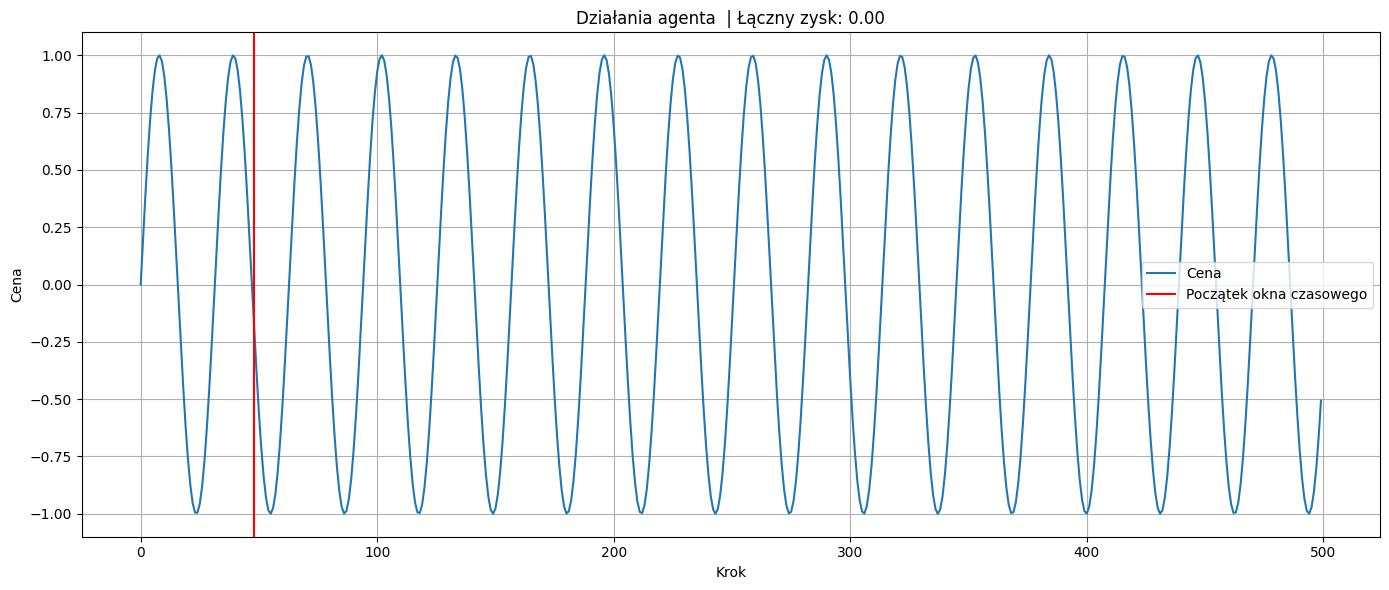

In [13]:
from eval_models import evaluate_steps, render_env

env.reset()
evaluate_steps(env, agent.target_model)
render_env(env, title_suffix="")

In [ ]:
from tqdm import tqdm

epsilon = 1
EPISODES = 40
# Iterate over episodes
avg_reward = 0
max_average_delta = -50
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    prev_revard = avg_reward
    avg_reward = train_parallel_episode(agent, envs, episode, epsilon, NUM_ENVS)
    print(avg_reward)
    if episode > 1 and prev_revard > 0 and prev_revard - avg_reward < max_average_delta:
        break
    #train_episode(agent,env, episode, 0.9)



  2%|2         | 1/40 [00:20<13:12, 20.32s/episodes]

-438.8713150024414


  5%|5         | 2/40 [00:39<12:30, 19.76s/episodes]

-122.38127708435059


  8%|7         | 3/40 [00:59<12:15, 19.88s/episodes]

-117.13250350952148


 10%|#         | 4/40 [01:20<12:04, 20.11s/episodes]

-84.59003448486328


 12%|#2        | 5/40 [01:40<11:46, 20.19s/episodes]

-531.1237182617188


 15%|#5        | 6/40 [02:00<11:23, 20.11s/episodes]

-147.05000114440918


 18%|#7        | 7/40 [02:20<11:01, 20.03s/episodes]

-142.01756477355957


 20%|##        | 8/40 [02:40<10:41, 20.04s/episodes]

10.543704986572266


 22%|##2       | 9/40 [03:01<10:26, 20.22s/episodes]

-304.01009368896484


 25%|##5       | 10/40 [03:20<10:01, 20.04s/episodes]

-409.7174987792969


 28%|##7       | 11/40 [03:41<09:47, 20.25s/episodes]

-401.7000331878662


 30%|###       | 12/40 [04:00<09:18, 19.94s/episodes]

-324.77627182006836


 32%|###2      | 13/40 [04:20<08:54, 19.81s/episodes]

-280.3750591278076


 32%|###2      | 13/40 [04:24<09:08, 20.32s/episodes]


KeyboardInterrupt: 

In [17]:
from rl_agent import save_dqn_agent

save_dqn_agent(agent, 'aapl_15min_norm_8env_newEpsilon.pth')

In [18]:
# ticker = "AAPL"
# other_ticker = retrive_market_data([ticker], duration = "1 M", time_interval = "15 mins")
# other_ticker = other_ticker[ticker]
# other_ticker['Volume'] = other_ticker['Volume'].astype(float)
# other_ticker['Date'] = pd.to_datetime(other_ticker['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
# other_ticker = other_ticker[col_select]
#other_ticker = (other_ticker - other_ticker.mean()) / other_ticker.std()


In [19]:
# test_env = TimeSeriesEnvFuturePredict_VEC(data=test_df['close'].values, lstm=lstm,lstm_data=test_df.values,device=device,
#                                  train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

# test_env = TimeSeriesEnvFuturePredict_VEC(
#                 data=rl_df['Close'].values, 
#                 lstm=lstm,
#                 lstm_data=rl_df.values,
#                 device=device,
#                 train_std=float(train_std[CLOSE_INDEX]),
#                 train_mean=float(train_mean[CLOSE_INDEX]), 
#                 window_size=48, 
#                 future_size=OUT_STEPS)


In [ ]:
data = np.sin(np.linspace(0, 100, 500)).astype(np.float32)


test_env = TimeSeries_VEC(
                data=test_df['close'].values, 
                #lstm=lstm,
                lstm_data=test_df.values,
                device=device,
                min_val=float(min_value),
                max_val=float(max_value), 
                window_size=48
                #future_size=OUT_STEPS
        )


NameError: name 'TimeSeries_VEC' is not defined

In [ ]:
# test_env = TimeSeriesEnvFuturePredict_VEC(data=other_ticker['Close'].values, lstm=lstm,lstm_data=other_ticker.values,device=device,
#                                  train_std = other_ticker.std()[CLOSE_INDEX],train_mean= other_ticker.mean()[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [ ]:
test_env._get_observation()

array([0.46323127, 0.46323127, 0.46266988, 0.46570107, 0.46491528,
       0.46480307, 0.4634557 , 0.46592566, 0.47064105, 0.47052884,
       0.46963066, 0.4719884 , 0.4716516 , 0.46671167, 0.46592566,
       0.4022679 , 0.4045133 , 0.4165264 , 0.41450542, 0.42337495,
       0.42483437, 0.42550814, 0.42247677, 0.42663074, 0.42584494,
       0.4298867 , 0.43538788, 0.4324689 , 0.43639845, 0.4448188 ,
       0.44044006, 0.43830705, 0.43460208, 0.4302235 , 0.4303357 ,
       0.4347143 , 0.43740886, 0.4344897 , 0.4314585 , 0.4316829 ,
       0.43853146, 0.4191086 , 0.42449757, 0.42887613, 0.42820254,
       0.4297743 , 0.42539576, 0.42494676], dtype=float32)

In [ ]:
def evaluate_steps_vec(env, model, device="cuda:0"):
    state,_ = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done, truncated, infos = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward



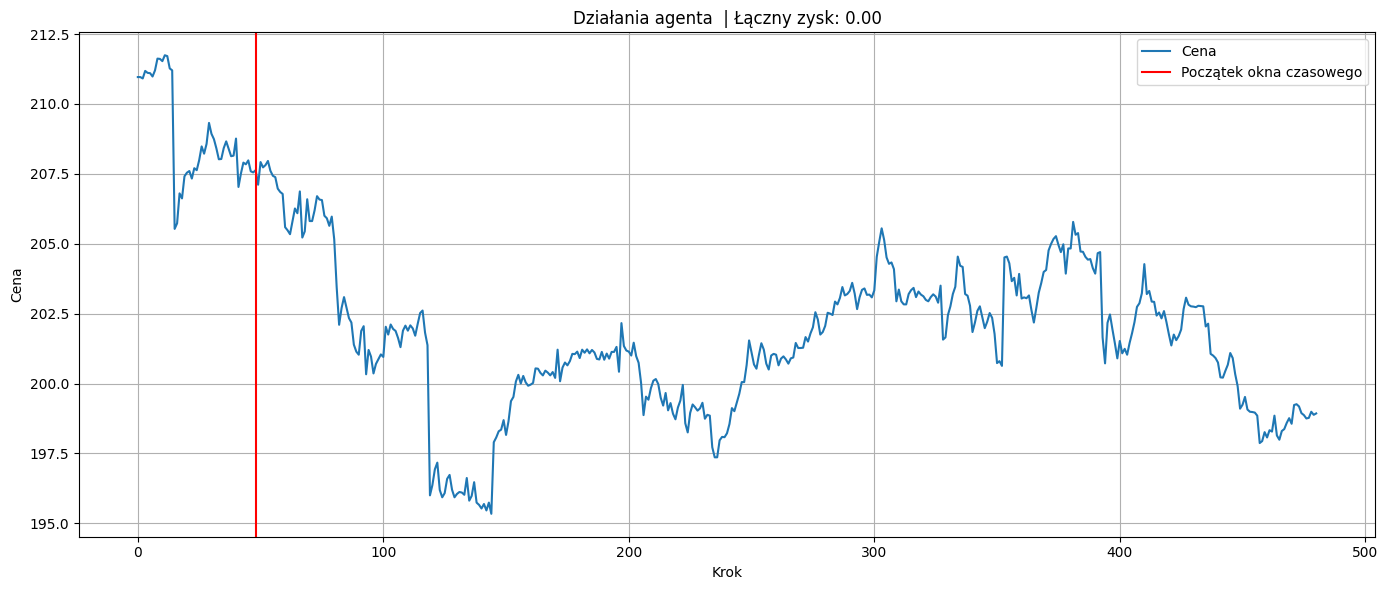

In [ ]:
from eval_models import evaluate_steps, render_env

test_env.reset()
#evaluate_steps(test_env, agent.target_model)
evaluate_steps_vec(test_env, agent.target_model, device=device)
render_env(test_env, title_suffix="")

In [ ]:
sum(test_env.inventory) - len(test_env.inventory) * test_env.data[-1]

0.0

In [ ]:
np.sum(test_env.data[-1] - test_env.inventory) 

0.0

In [ ]:
test_env.data[-1]

198.93

In [ ]:
test_env.inventory

[]